Using the attached dataset, please create a notebook (preferably Python but any tool is allowed) to explore the data in order to answer questions like:
+ **How would you make a geo expansion recommendation?**
+ **What new columns would you create?**
+ **How might clustering analysis help - how would you go about it?**

However, use these questions just as a starting point, and feel free to also use your own creativity/inspiration

In the interview process, we'll ask you to take us through your notebook, thought process and the libraries that you've used. A presentation/deck of any kind is not necessary.

[Metadata](https://carto.com/spatial-data-catalog/browser/dataset/acs_sociodemogr_f7ba0b77/data)

In [2]:
import pandas as pd 
import seaborn as sns
import contextily as ctx

import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from sklearn import cluster
#import pysal.contrib.clusterpy as cp


In [3]:
#loading provided dataset
df = pd.read_excel('./US Census Dataset.xlsx')
df.head()

,ID,total_pop,male_pop,female_pop,pop_25_years_over,median_age,median_income,income_per_capita,gini_index,median_rent,black_pop,hispanic_pop,white_pop,geom
0,0,48970,24123,24847,26944,27.0,51972.0,21486.0,0.3620,853.0,16810,11761,14301,"MULTIPOLYGON(((-97.874316 31.077931, -97.87367..."
1,1,809,376,433,612,56.2,29087.0,21153.0,0.4452,370.0,127,31,651,"POLYGON((-95.793207 32.036901, -95.805474 32.0..."
2,2,2330,1198,1132,1650,46.0,56400.0,29967.0,0.4528,533.0,276,254,1691,"POLYGON((-79.073703 35.659202, -79.074482 35.6..."
3,3,22171,11234,10937,15022,38.3,73226.0,30397.0,0.4187,1297.0,377,11256,8195,"POLYGON((-121.71859 36.814383, -121.715383 36...."
4,4,2829,1485,1344,2033,41.2,35064.0,20576.0,0.4633,481.0,41,21,2727,"POLYGON((-81.587423 37.749221, -81.595335 37.7..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33120 entries, 0 to 33119
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 33120 non-null  int64  
 1   total_pop          33120 non-null  int64  
 2   male_pop           33120 non-null  int64  
 3   female_pop         33120 non-null  int64  
 4   pop_25_years_over  33120 non-null  int64  
 5   median_age         32553 non-null  float64
 6   median_income      30956 non-null  float64
 7   income_per_capita  32478 non-null  float64
 8   gini_index         32211 non-null  float64
 9   median_rent        27018 non-null  float64
 10  black_pop          33120 non-null  int64  
 11  hispanic_pop       33120 non-null  int64  
 12  white_pop          33120 non-null  int64  
 13  geom               33120 non-null  object 
dtypes: float64(5), int64(8), object(1)
memory usage: 3.5+ MB


In [5]:
df.columns

Index(['ID', 'total_pop', 'male_pop', 'female_pop', 'pop_25_years_over',
       'median_age', 'median_income', 'income_per_capita', 'gini_index',
       'median_rent', 'black_pop', 'hispanic_pop', 'white_pop', 'geom'],
      dtype='object')

<AxesSubplot:>

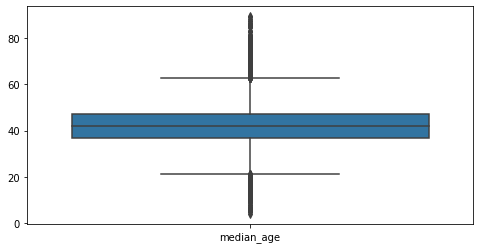

In [6]:
plt.figure(figsize=(8,4))
#sns.boxplot(data=df[['male_pop','female_pop', 'pop_25_years_over']])
sns.boxplot(data=df[['median_age']])

<AxesSubplot:>

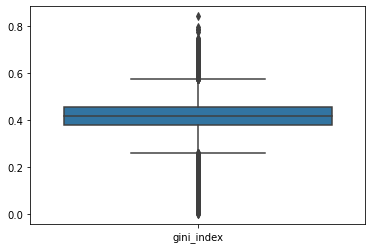

In [7]:
sns.boxplot(data=df[['gini_index']])         

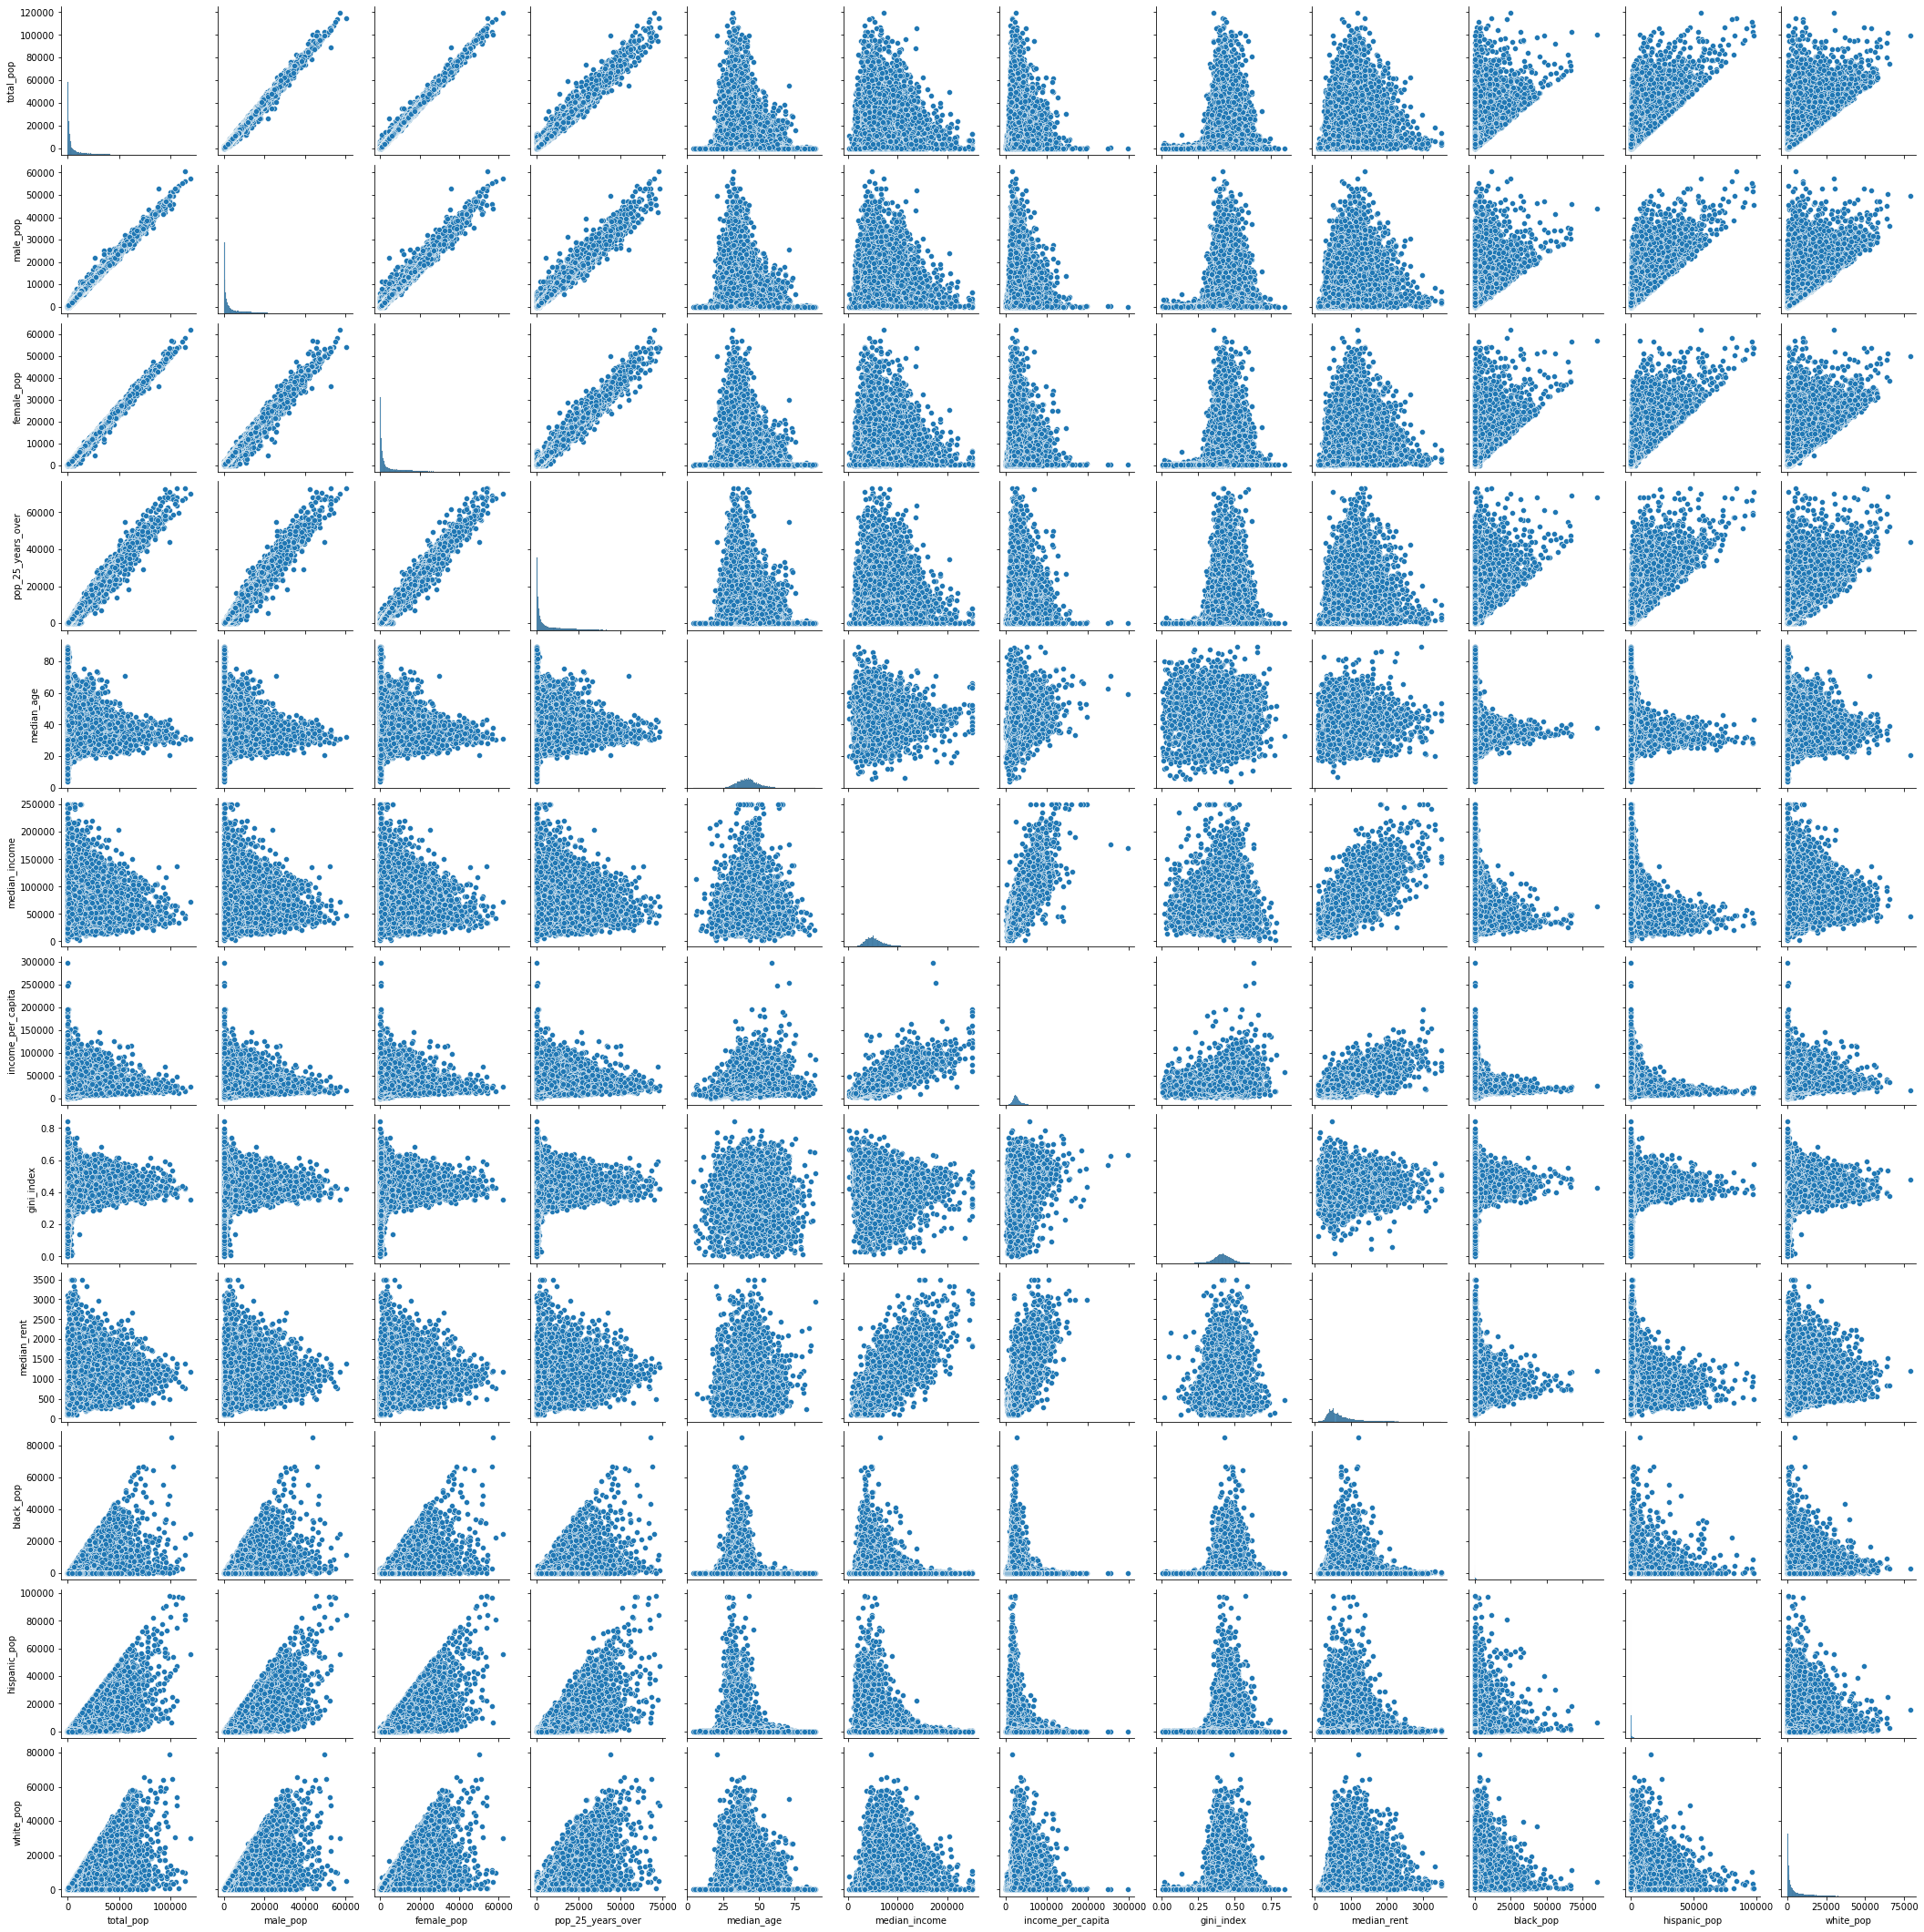

In [8]:
# Create the default pairplot - check if there's any obvious correlation
sns.pairplot(df[['total_pop', 'male_pop', 'female_pop', 'pop_25_years_over',
       'median_age', 'median_income', 'income_per_capita', 'gini_index',
       'median_rent', 'black_pop', 'hispanic_pop', 'white_pop']])

In [9]:
#Checking geometry + viz
#creating geodataframe

Creating GeoDataFrame using conventional way throws an error, which indicates that there are issues with WKT

```python
gdf = gpd.GeoDataFrame(df, geometry=df['geom'])
```
Looking at the data in QGIS, the assumption that there are extra numbers (or numbers removed from a pair) which distorts geometry
<img src="./images/qgis_wkt_issue.png" alt="qgis_wkt_issue" width="600"/>

In [10]:
#Fixing geomertry using shapely
from shapely import wkt

geom = []

for g in df['geom']:
    try:
        geom.append(wkt.loads(g))
    except:
        geom.append(None)

df['geometry'] = geom

ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered word: '-'
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected

ParseException: Expected number but encountered end of stream
ParseException: Expected word but encountered end of stream
ParseException: Expected number but encountered end of stream
ParseException: Expected number but encountered end of stream


In [11]:
#chekcing for empty geometries
df["geometry"].isna().sum()

139

In [12]:
df.dropna(subset=['geometry'], inplace=True)

In [13]:
gdf = gpd.GeoDataFrame(df, geometry=df['geometry'])
#CRS check
print(gdf.crs)

None


<AxesSubplot:>

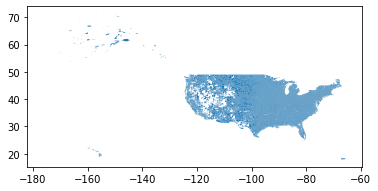

In [14]:
#quick check that data looks OK
gdf.plot()

In [15]:
#As this data covers US and is US cencus NAD83 or WGS84 coudl be used (differences will not have effect on this scale)
# setting CRS to WGS84 to avoid possilbe CRS conversions later if/when adding addtional datasets

gdf.set_crs(epsg=4326, inplace=True)
gdf.head()

,ID,total_pop,male_pop,female_pop,pop_25_years_over,median_age,median_income,income_per_capita,gini_index,median_rent,black_pop,hispanic_pop,white_pop,geom,geometry
0,0,48970,24123,24847,26944,27.0,51972.0,21486.0,0.3620,853.0,16810,11761,14301,"MULTIPOLYGON(((-97.874316 31.077931, -97.87367...","MULTIPOLYGON (((-97.87432 31.07793, -97.87367 ..."
1,1,809,376,433,612,56.2,29087.0,21153.0,0.4452,370.0,127,31,651,"POLYGON((-95.793207 32.036901, -95.805474 32.0...","POLYGON ((-95.79321 32.03690, -95.80547 32.035..."
2,2,2330,1198,1132,1650,46.0,56400.0,29967.0,0.4528,533.0,276,254,1691,"POLYGON((-79.073703 35.659202, -79.074482 35.6...","POLYGON ((-79.07370 35.65920, -79.07448 35.660..."
3,3,22171,11234,10937,15022,38.3,73226.0,30397.0,0.4187,1297.0,377,11256,8195,"POLYGON((-121.71859 36.814383, -121.715383 36....","POLYGON ((-121.71859 36.81438, -121.71538 36.8..."
4,4,2829,1485,1344,2033,41.2,35064.0,20576.0,0.4633,481.0,41,21,2727,"POLYGON((-81.587423 37.749221, -81.595335 37.7...","POLYGON ((-81.58742 37.74922, -81.59534 37.742..."


C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\contextily\tile.py:583: RuntimeWarning: divide by zero encountered in log2
  zoom_lon = np.ceil(np.log2(360 * 2.0 / lon_length))


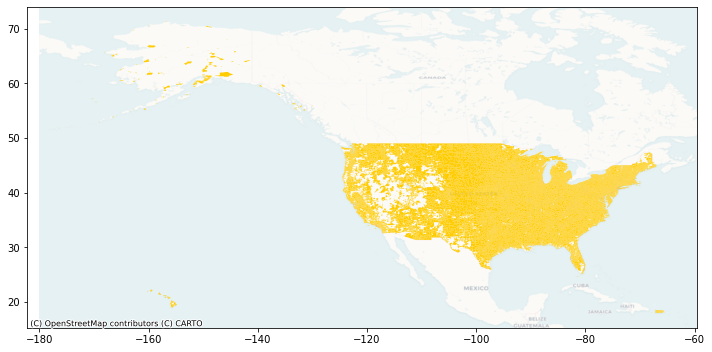

In [17]:
#Better visualisaton with some background mapping


fig, ax = plt.subplots(figsize=(12,8))

# Plot the data
#os_data.plot(ax=ax)
gdf.plot(color = '#ffcc00',ax=ax)
# Add basemap

ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Voyager, alpha = 0.6)

#Even better interactive mapping

map = folium.Map(location = [30.266666,-97.733330], tiles = "OpenStreetMap", zoom_start = 10)

for _, r in df.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,style_function=lambda x: {'color': '#ffcc00'})
    geo_j.add_to(map)
map

# Variable viz

## Choropleth mapping to visually investigate data

In [18]:
ethnic_groups = ['black_pop', 'hispanic_pop', 'white_pop']

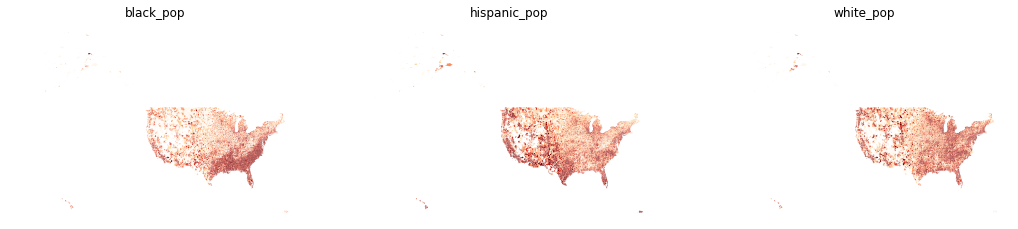

In [46]:
# Create figure and axes 
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the ethnic_groups
for i, col in enumerate(ethnic_groups):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf.plot(column=col, ax=ax, scheme='Quantiles', linewidth=0, cmap='OrRd')
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()


### TO-DO 

Calculate median age from the  chart using those who either used or is using the dating app.

Then it could be used with median age in a data

## Target users 

 This [data](https://www.statista.com/statistics/310344/us-online-dating-app-site-usage-age/) suggests that main users off dating apps are  _**18 - 44**_
 

In [47]:
#Simplistic way
#extract only this age group - this is our target group
#check where those people live

gdf_18_29 = gdf.loc[(gdf['median_age'] >= 18) & (df['median_age'] <45) ]

In [22]:
#subselecting above average median income to subselect those who could afford premium features

gdf_18_29_high_inc = gdf_18_29.loc[(gdf_18_29['median_income'] >=  gdf_18_29['median_age'].mean()) ]

print(len(gdf_18_29))
print(len(gdf_18_29_high_inc))

In [24]:
#selecting dominant ethnic group from three present groups
gdf_18_29_high_inc['dominant_ethnic_group'] = gdf_18_29_high_inc[['black_pop', 'hispanic_pop', 'white_pop']].idxmax(axis=1)

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [25]:
# minimising dataset by dissolving boundaries based on the value
# dissolve the state boundary by region 
dominant_group = gdf_18_29_high_inc.dissolve(by='dominant_ethnic_group')

<AxesSubplot:>

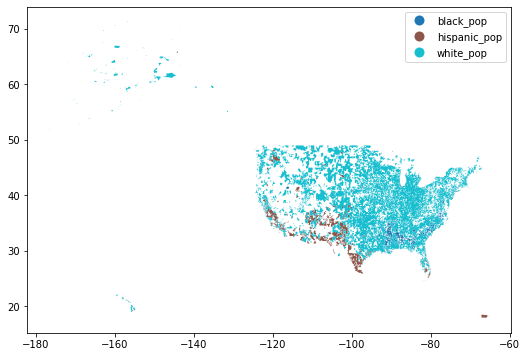

In [26]:
 # create the plot
fig, ax = plt.subplots(figsize = (10,6))

# plot the data 
dominant_group.reset_index().plot(column = 'dominant_ethnic_group',legend=True, ax=ax)


In [27]:
#creating polygon centroids to use them for clustering

gdf_18_29_high_inc_centroids = gdf_18_29_high_inc.copy()

# change geometry 
gdf_18_29_high_inc_centroids['geometry'] = gdf_18_29_high_inc['geometry'].centroid

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [31]:
#gdf_18_29_high_inc_centroids.plot()

In [69]:
kmeans3 = cluster.KMeans(n_clusters=3)
k3cls = kmeans6.fit(gdf_18_29_high_inc[ethnic_groups])
gdf_18_29_high_inc['k3cls'] = k6cls.labels_

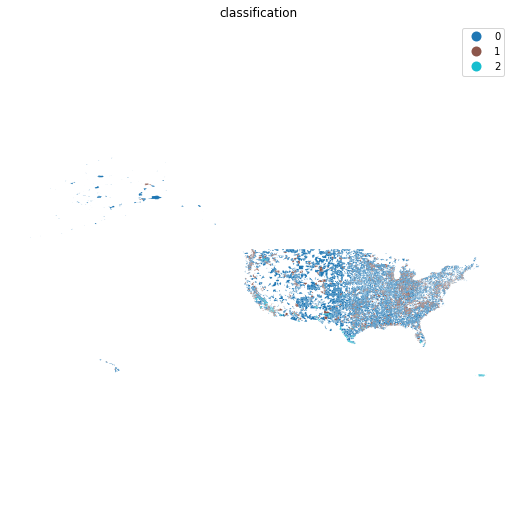

In [72]:
## Mapping the categories

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
gdf_18_29_high_inc.plot(column='k6cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('classification')
# Display the map
plt.show()

In [70]:
#Viz to show clusters on a separate plot

In [73]:
clusters = gdf_18_29_high_inc['k3cls'].unique()

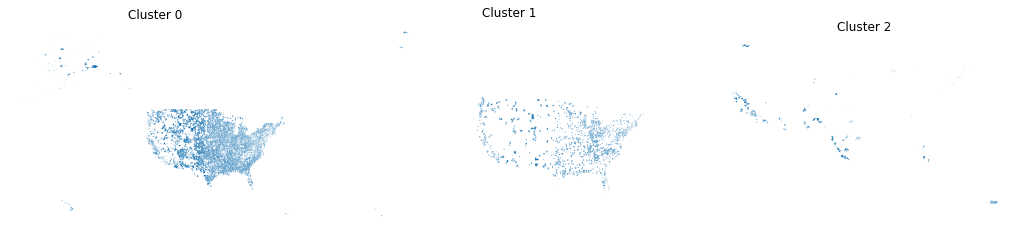

In [75]:
# Create figure and axes 
f, axs = plt.subplots(nrows=1, ncols=3, 
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start the loop over all the ethnic_groups
for i in clusters:
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    gdf_18_29_high_inc.loc[(gdf_18_29_high_inc['k3cls']==i)].plot(ax=ax)
    #gdf_18_29_high_inc.plot(column=col, ax=ax, scheme='Quantiles', linewidth=0, cmap='OrRd')
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title('Cluster '+str(i))
# Display the figure
plt.show()

### _Summary_
I would target **Cluster 2** with prelevant hispanic population :
+ they are concentrated/ clustered
+ on a higher then average income
+ target age group


Cluster 0 ( white population) is wide spread, so further refinement is needed

Cluster 1 ( black population) is less wide spread than Cluster 1, but still could be refined

In [41]:
#diss = gdf_18_29_high_inc.dissolve("k5cls").convex_hull

In [44]:
#diss.plot( legend=True)

In [ ]:
compare my age subselection with  pop_25_years_over 

### TO-DO 

calculate  percent of each ethnic group

map highest percent 

In [80]:
#creating centroids of main gdf
centroids_all = gdf.copy()
centroids_all['geometry'] = centroids_all['geometry'].centroid

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
#removeing geom column to keep data tidy
centroids_all.drop(columns='geom',inplace = True)

In [85]:
#centroids_all.columns

In [92]:
centroids_all.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## State - level expansion

In [76]:
#adding new data

usa = gpd.read_file("data/cb_2018_us_state_20m.shp")
usa.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ..."
1,19,01779785,0400000US19,19,IA,Iowa,00,144661267977,1084180812,"POLYGON ((-96.62187 42.77925, -96.57794 42.827..."
2,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"POLYGON ((-75.77379 39.72220, -75.75323 39.757..."
3,39,01085497,0400000US39,39,OH,Ohio,00,105828882568,10268850702,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ..."
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,115884442321,3394589990,"POLYGON ((-80.51989 40.90666, -80.51964 40.987..."


In [77]:
#check crs
usa.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [93]:
# Make a spatial join
join_gdf = gpd.sjoin(centroids_all, usa.to_crs(epsg=4326), how="inner", op="within")

In [157]:
#join_gdf.head()

In [158]:
#join_gdf.to_file("usa_centroids_joined.shp")

In [121]:
#mean rent and income by state
rent_income = join_gdf.groupby('NAME')['median_rent','median_income'].mean().reset_index().sort_values(by='median_rent')

C:\Users\ng93n\anaconda3\envs\gis\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [122]:
#Let's join GeoDataFrame usa with DataFrame rent_income based on state
rent_income_usa = pd.merge(rent_income, usa, on='NAME')

In [123]:
from splot.mapping import vba_choropleth

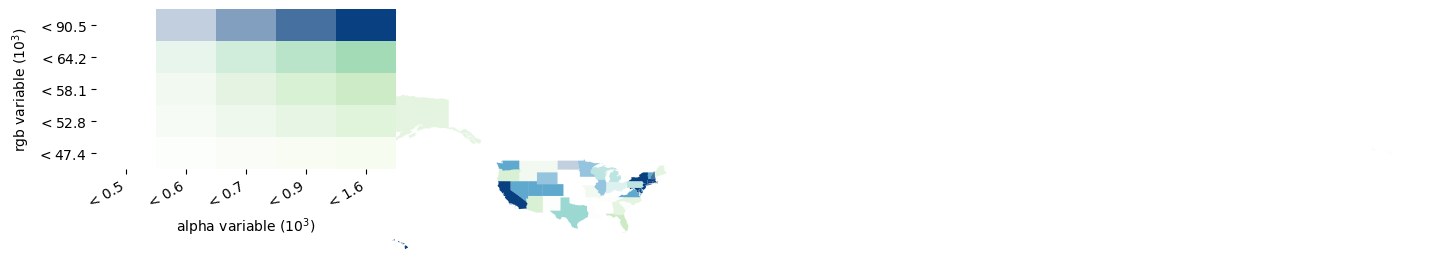

In [156]:
fig1 = plt.figure(figsize=(15,8))
ax = fig1.add_subplot(111)
vba_choropleth( rent_income_usa['median_income'].values, 
               rent_income_usa['median_rent'].values, 
               rent_income_usa,
               alpha_mapclassify=dict(classifier='quantiles', k=5),
               rgb_mapclassify=dict(classifier='quantiles', k=5),
               legend=True,
               ax=ax)
plt.show()

### _Summary_

Darker coloured states are those with  the high averaged of median_income by state

Transparency indicates the averaged median rent by the state

In [166]:
#top 10 
rent_income.sort_values(by=['median_income','median_rent'], ascending=False).iloc[0:10]

,NAME,median_rent,median_income
30,New Jersey,1250.631776,90503.021053
8,District of Columbia,1554.333333,86625.416667
6,Connecticut,1057.581967,86145.520755
20,Maryland,1122.646893,85278.103211
21,Massachusetts,1082.240664,82165.825243
40,Rhode Island,903.940299,73705.305556
29,New Hampshire,892.190909,72435.278689
4,California,1220.753111,68780.077586
32,New York,915.669188,67921.100724
11,Hawaii,1172.691358,66766.809524
